# Kaggle survey and notebook submissions meta-analysis

---

# **Introduction**

## The data hidden in data.
The Kaggle Survey competitions have appeared annually since 2017. Each year numerous competitors submit notebooks wherein they analyse the competition dataset - the respondents’ answers to the survey questions. We've decided to do something different. To challenge ourselves, we've decided to inspect the data hidden in data: We analyse the notebooks of kagglers which participated in past kaggle survey competitions, as well as they survey questions themselves. # TODO make everything in same tense.

These were our main topics of focus:

    i) Survey question analysis: What kinds of questions are posed by the survey; Do they change over time and can a trend be glimpsed from these changes?

    ii) Competition notebooks analysis: Can we see any trends in submitted notebooks like language used and kaggle tiers of participants? Which themes were the competition participants most often interested in? Which libraries did they use in their notebooks? How is notebook success best measured? Does it depend on the experience of participants?
    
Continue reading to find the answers to all these questions.. and more.

---

# **Data overview**

## Data Acquisition

The nature of the work we have decided to undertake required us to generate our own datasets. It was one of the main efforts of our project as well as a fun challenge. This section gives an overview of the work involved.

We wrote the **ETL** (*extract-transform-load*) scraping code in Python and made it publicly accessible in our GitHub repository: https://github.com/moratsam/kaggle-survey-2022, we kindly invite you to have a look at it. **# TODO make public.**

We have compiled data about every kernel that participated in any Kaggle Survey Competition since 2017, when the annual survey began. The data structure looks like this:

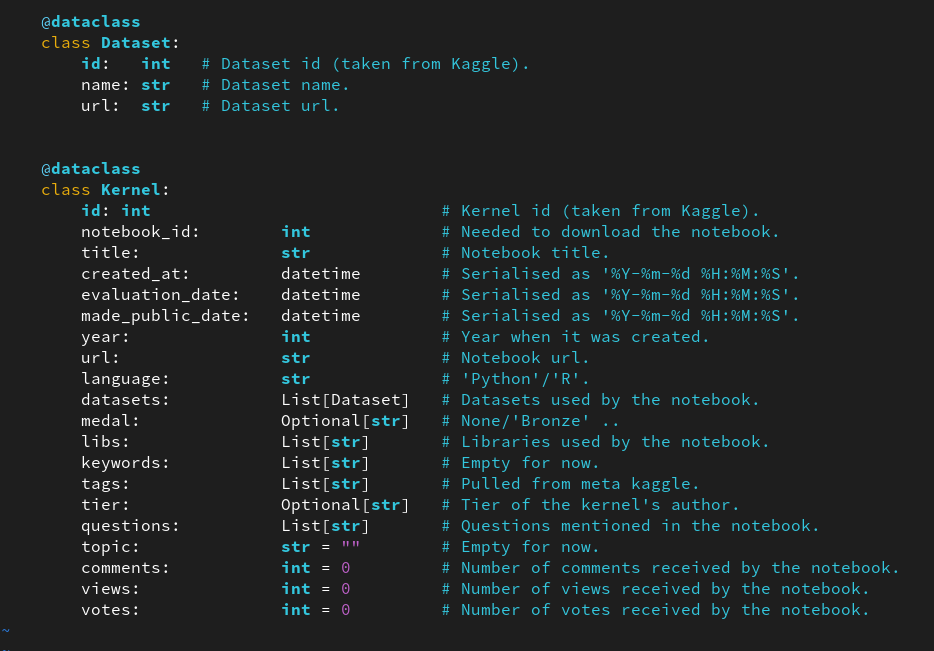


Most of this data is taken directly from scraping *Kaggle.com*; when one opens the ***Code*** section of a Kaggle competition or dataset page, one can see the notebooks which competed in this competition or used this dataset. The notebooks get loaded via ***POST requests*** made to an internal Kaggle API available at *https://www.kaggle.com/api/i/kernels.KernelsService/ListKernels*. We programatically intercepted this traffic and parsed it to obtain the kernel data.

The fields ***created_at***, ***evaluation_data***, ***made_public_date***, ***year***, ***tags*** and ***tier*** were taken from the official [Meta Kaggle dataset](https://www.kaggle.com/datasets/kaggle/meta-kaggle).

The fields ***libs***, which is a list of libraries imported by a notebook, and ***questions***, which is a list of questions addressed by a notebook, were populated by parsing each kernel's raw notebook.



## Dataset Structure

We have order our data into several distinct datasets, each of which was useful in obtaining answers to our questions on at least one of the topics. # TODO rewrite this.

The obtained datasets are briefly overviewed below.

   
* **notebooks.zip**

   Contains 1822 raw notebooks saved as either `ipynb` or `Rmd`. 58 notebooks could not be executed neither in Python nor in R, so they were given the extension `unknown_format.txt`. The name of each file is the `notebook_id` as listed on `kaggle.com` and matches `notebook_id` in the file `all_kernels.csv`, which is described below. Among other things, this dataset was used to obtain a per-notebook list of imported libraries, as well as the questions that were addressed by each notebook.
   

* **all_kernels.csv**
   1822 kernels used any Kaggle Survey dataset in the years 2017-2021. This dataset contains each kernel as a row, and the columns correspond  to all the fields listed in the Kernel class image above. A more detailed overview of the of the columns can be found on the [dataset's Kaggle page](https://www.kaggle.com/datasets/jakkajdsfs/kaggle-survey-historical-meta).
   
   
* **cleaned_kernels.csv**
    This is in effect the main dataset. We took the ***all_kernels.csv*** and removed from it 233 rows which described kernels which were just unchanged forks of other kernels. # TODO klemen a znas to malo bolje napisat?


* **all_questions.json**
   
   Contains all Kaggle Survey questions from the years 2017-2022. In the year 2017, the survey questions were unnumbered, so we numbered them ourselves, keeping the original order and using zero-based indexing. Surveys 2018-2022 have numbered questions, so they were taken unchanged.


* **question_map.csv**
   
   Looking at survey questions over several years, one can note that certain questions repeat. For example, every year's survey contains a question `What is your age`. All such repetitions are captured in this dataset. For each unique question, the question number and the survey year where this question appears is given. The question numbers are described in the preceding paragraph `sorted_questions_all.json`. Certain questions are worded differently but functionally identical. If such questions were joined, a note was added, to alert other users of this dataset.

---

# Kaggle Survey Analysis

Data science is a fast-evolving field. New technologies are always emerging, replacing older ones in the process. We wanted to explore if this is reflected in the questions posed by the survey throughout the years. TODO: opisat situacijo v tevu, dodat kšn link

In [25]:
import json
import os
import string
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud

### Number of Questions containing the word 'cloud'
Counting every year's questions which contain the word "cloud", we arrive at the following result.

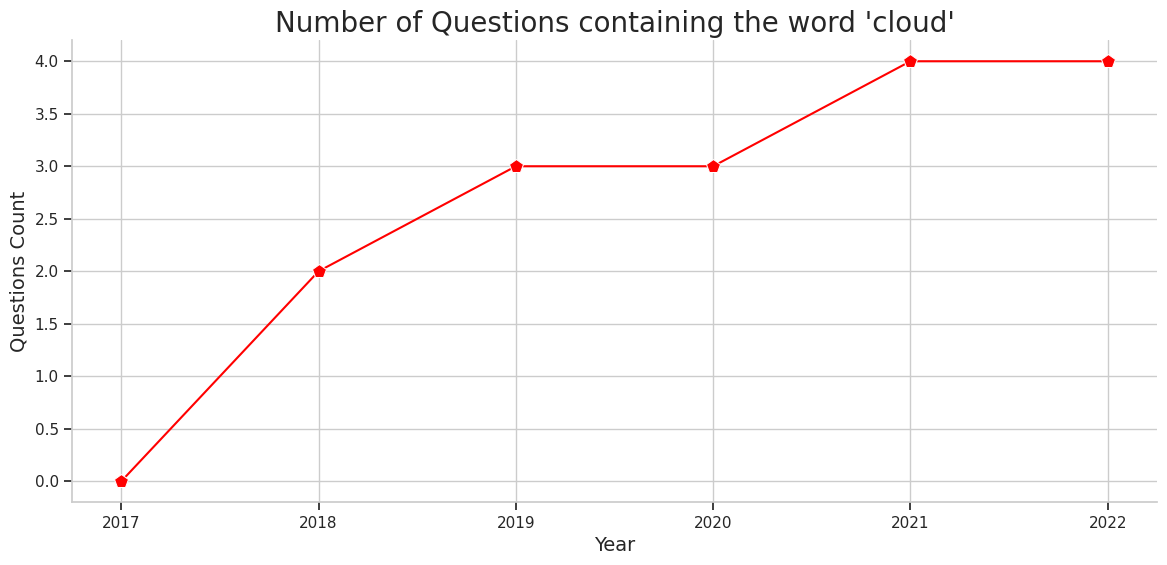

In [26]:
#with open('../input/kaggle-survey-historical-meta/all_questions.json') as f:
with open('kaggle-survey-historical-meta/all_questions.json') as f:
    all_qs = json.load(f)

cloud_cnts = {year: 0 for year in range(2017, 2023)}
for year in all_qs:
    for question in all_qs[year].values():
         if 'cloud' in question:
             cloud_cnts[int(year)] += 1

cloud_series = pd.Series(cloud_cnts)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(14,6))


sns.lineplot(x=cloud_series.index, y=cloud_series, marker='p',markersize= 10, color='red')
plt.title("Number of Questions containing the word 'cloud'",fontsize=20)
plt.xlabel('Year', fontsize=14);
plt.ylabel('Questions Count', fontsize=14)
plt.tick_params(bottom=True, left=True)

plt.show()

We can see the number of questions referring to cloud technology is growing throughout the years which correlates very nicely with the growing popularity of cloud solutions in data science. TODO: primerjat rezultate s trendi po svetu (najbolj še kakšen link dodat).

### Answer choices to question 'Which types of specialized hardware do you use on a regular basis?' by Year
Plotting the choices given by the surveys in answer to the question`Which types of specialized hardware do you use on a regular basis?` *[1]*, we obtain the following heatmap:

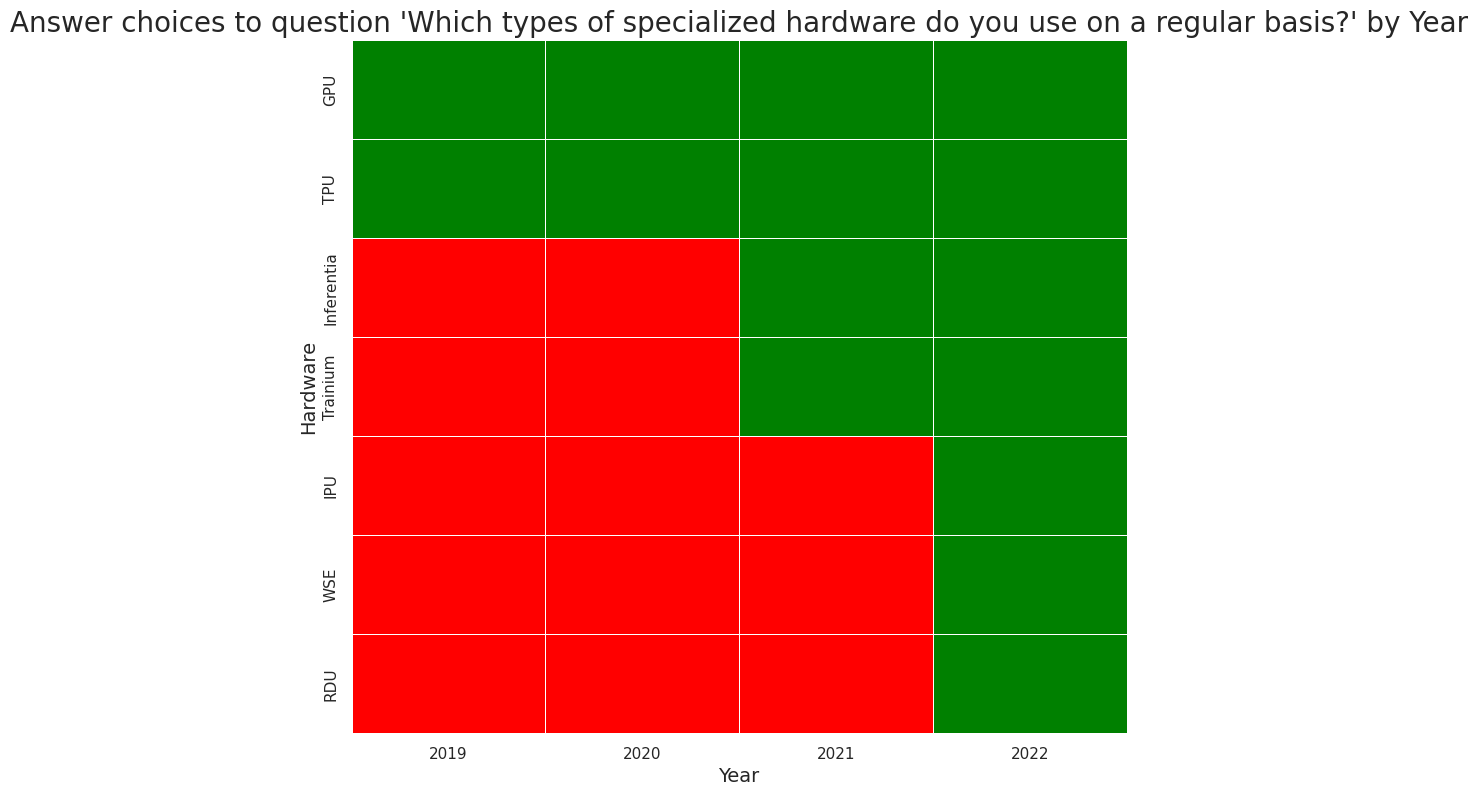

In [27]:
#hardware = pd.read_csv('/kaggle/input/question-analysis/hardware.csv')
hardware = pd.read_csv('question-analysis/hardware.csv')

hardware = hardware.set_index('Hardware')

plt.figure(figsize=(10,9))

sns.heatmap(
    hardware, 
    annot=False,
    cmap=["red","green"],
    cbar=False,
    linewidth=.5)
plt.title("Answer choices to question 'Which types of specialized hardware do you use on a regular basis?' by Year",fontsize=20)
plt.xlabel('Year', fontsize=14);
plt.ylabel('Hardware', fontsize=14)

plt.show()

We can see the emergence of new specialized hardware. In 2021 inferentia and titanium appeared as answer choices. In year 2022 IPU, RSE and RDU also appeared. 
TODO: primerjat rezultate s trendi po svetu (najbolj še kakšen link dodat).

### Answer choices to question 'Which machine learning frameworks do you use on a regular basis?' by Year
Plotting the choices given by the surveys when asking about the usage of machine learning frameworks *[2]*, we arrive at the following heatmap:

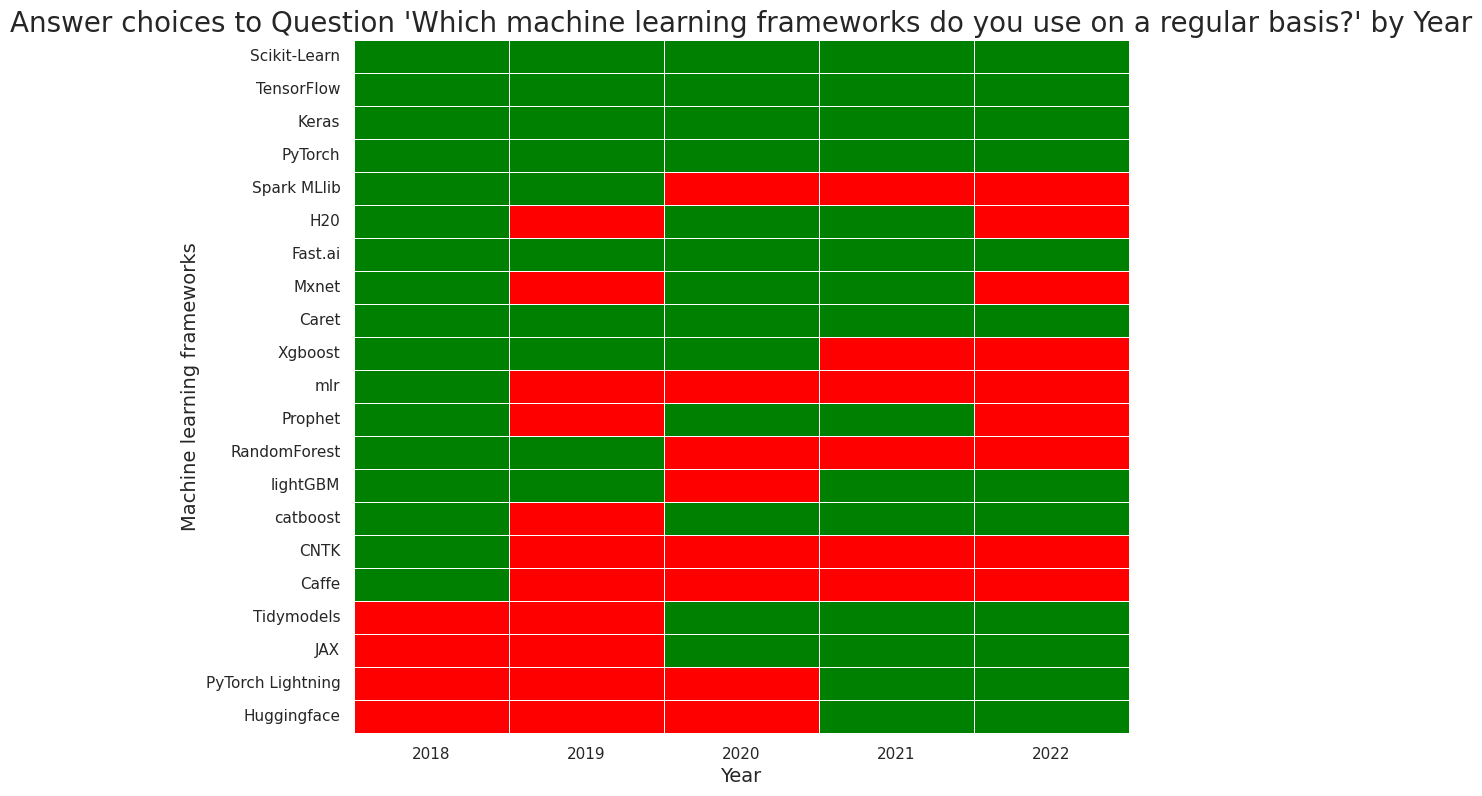

In [28]:
#ml_frameworks = pd.read_csv('/kaggle/input/question-analysis/ml_frameworks.csv')
ml_frameworks = pd.read_csv('question-analysis/ml_frameworks.csv')
ml_frameworks = ml_frameworks.set_index('Framework')
plt.figure(figsize=(10,9))
sns.heatmap(
    ml_frameworks, 
    annot=False,
    cmap=["red","green"],
    cbar=False,
    linewidth=.5)
plt.title("Answer choices to Question 'Which machine learning frameworks do you use on a regular basis?' by Year",fontsize=20)
plt.xlabel('Year', fontsize=14);
plt.ylabel('Machine learning frameworks', fontsize=14)

plt.show()

We can see the emergence of new ML frameworks and the dissaperance of others from the answer choices. TODO: opisat katere, primerjat rezultate s trendi po svetu (najbolj še kakšen link dodat).

---

# Competition Notebooks Analysis

There have been many excellent notebook submissions in the Kaggle Survey competitions. Let's see what we can learn from them.

In [20]:
# data cleaning
#df = pd.read_csv(r'C:\Users\Klemen\Documents\Data Science\Kaggle\Survey2022\all_kernels.csv')
#df = df.drop_duplicates(subset=['title'], keep='first')
#df = df[~df['title'].str.contains('Fork|fork|Regression')]

#df.to_csv(r'C:\Users\Klemen\Documents\Data Science\Kaggle\Survey2022\kaggle_survey_challenge_all_kernels.csv')

In [21]:
#cleaned_kernels_df = pd.read_csv(r'C:\Users\Klemen\Documents\Data Science\Kaggle\Survey2022\cleaned_kernels.csv')
cleaned_kernels_df = pd.read_csv('kaggle-survey-historical-meta/cleaned_kernels.csv')

## 1) Trends

### Number of Notebook Submissions by Year
Below we show the number of notebook submissions by year, from 2017 to 2021.

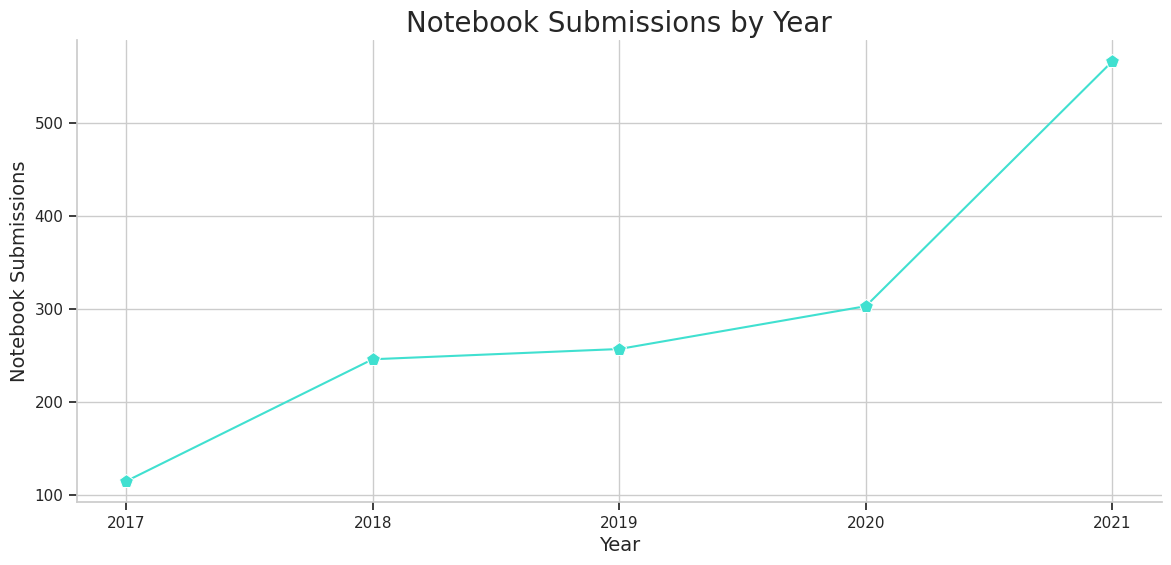

In [22]:
# remove rows where year is 1970 or 2022.
without_null_df = cleaned_kernels_df.loc[~cleaned_kernels_df['year'].isin([1970, 2022])]

# create a count dataframe
submissions_df = without_null_df.year.value_counts().rename('submissions_count').reset_index()

# draw a lineplot
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(14,6))

submissions_plot = sns.lineplot(data=submissions_df,
                                 x="index",
                                 y='submissions_count',
                                 color='turquoise',
                                 marker='p',
                                 markersize=10)
submissions_plot.set_xticks(range(2017, 2022), labels=range(2017, 2022))
plt.title('Notebook Submissions by Year',fontsize=20)
plt.xlabel('Year', fontsize=14);
plt.ylabel('Notebook Submissions', fontsize=14)
plt.tick_params(bottom=True, left=True)

plt.show() # TODO na abscisi so .5 oznake.

The Kaggle survey competitions seems to be growing in popularity, as notebook submissions increase every year (the data for 2022 is incomplete, we will see if that still holds). There is an especially big jump in year 2021, where notebook submissions grew by more than 100%.

### Language used by Year
In the plot below we show how the choice of programming language changed throughout the years.

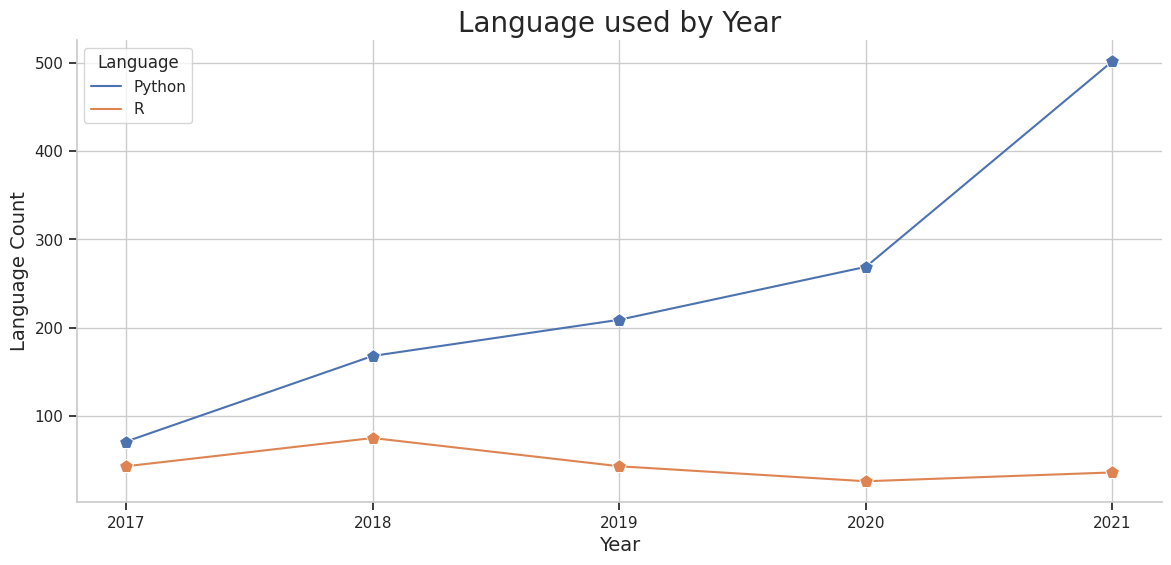

In [23]:
without_unknown_language_df = without_null_df.loc[without_null_df['language'] != 'UNKNOWN']
languages_df = without_unknown_language_df.groupby('year').language.value_counts().rename("language_count").reset_index()

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(14,6))

languages_plot = sns.lineplot(data=languages_df,
                         x='year',
                         y='language_count',
                         hue = 'language',
                         marker="p",
                         markersize=10)
languages_plot.set_xticks(range(2017, 2022), labels=range(2017, 2022))
plt.title('Language used by Year', fontsize=20)
plt.xlabel('Year', fontsize=14);
plt.ylabel('Language Count', fontsize=14)
plt.tick_params(bottom=True, left=True)
plt.legend(loc='upper left', title='Language')

plt.show()

Python usage is growing, while R usage is declining. In 2017 python was used in 62.3% of submissions, while 47.7% used R. In 2021 python was used in 93.3% of submissions while only 6,7% used R.

### Kaggle Tiers by Year
In this plot we explore how kaggle tiers of participants changed throughout the years.

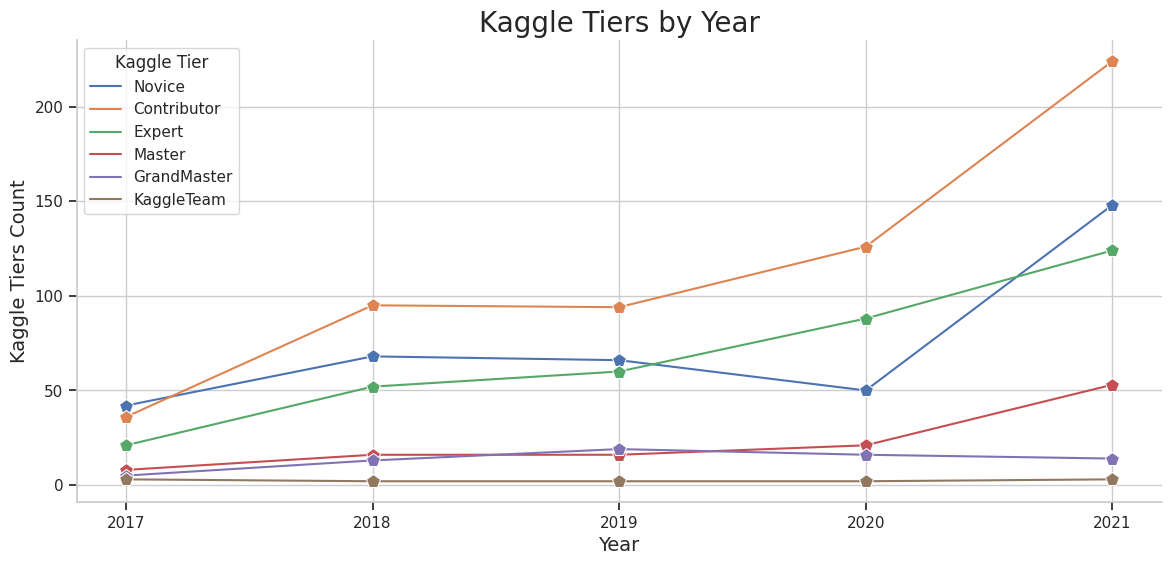

In [24]:
tiers_df = without_null_df.groupby('year').tier.value_counts().rename("tier_count").reset_index()

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(14,6))

tiers_plot = sns.lineplot(data=tiers_df,
                         x='year',
                         y='tier_count',
                         hue = 'tier',
                         marker="p",
                         markersize=10)
tiers_plot.set_xticks(range(2017, 2022), labels=range(2017, 2022))
plt.title('Kaggle Tiers by Year', fontsize=20)
plt.xlabel('Year', fontsize=14);
plt.ylabel('Kaggle Tiers Count', fontsize=14)
plt.tick_params(bottom=True, left=True)
plt.legend(loc='upper left', title='Kaggle Tier')

plt.show()

In the first survey challenge novices were the most frequent tier. The were soon overtaken by contributors as the tier of most participants. Experts seem to also take more interest in this challenge, as their group continues to grow.

---

## 2) Text 

### Popular Libraries used by participants
In this plot we examine which are the most popular libraries used by participants in their notebooks.

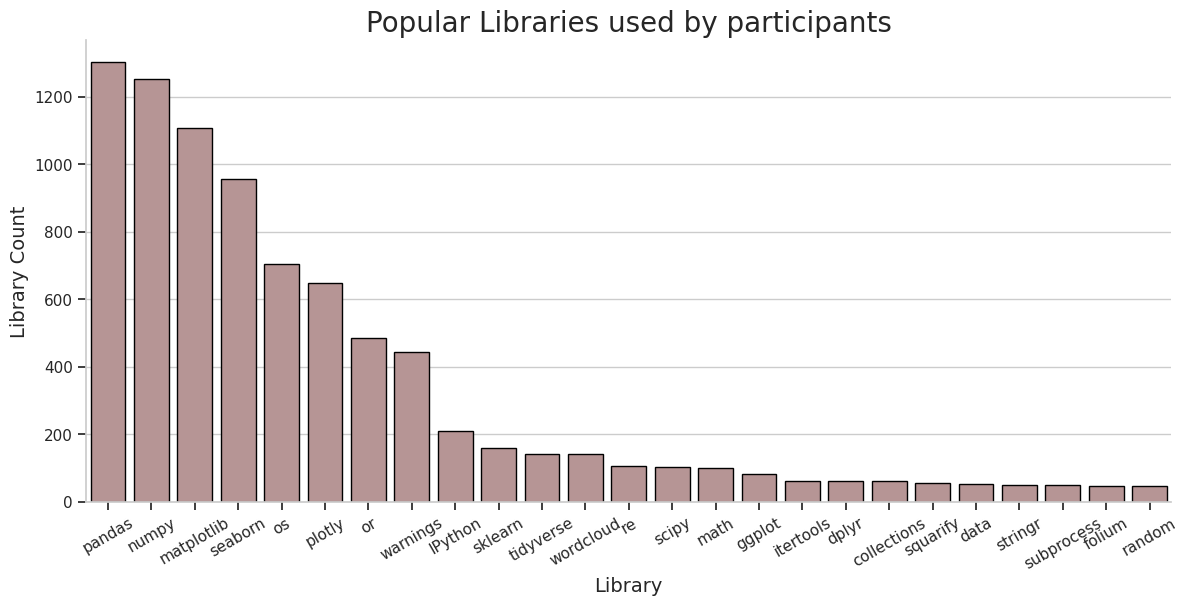

In [11]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
libs_arr = []
for index, row in cleaned_kernels_df.iterrows():
        libs_arr.append(row['libs'])
        
libs = ' '.join(libs_arr).translate(str.maketrans('', '', string.punctuation)).split()
libs_count = Counter(libs)

libs_df = pd.DataFrame(libs_count.items(), columns = ['Library', 'Library Count'])
libs_df = libs_df.sort_values(by=['Library Count'], ascending = False).head(25)


custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(14,6))

libs_plot = sns.barplot(data=libs_df, 
                        x='Library',
                        y='Library Count',
                        edgecolor='black',
                        color='rosybrown')
plt.xticks(rotation=30)
plt.title('Popular Libraries used by participants',fontsize=20)
plt.xlabel('Library', fontsize=14);
plt.ylabel('Library Count', fontsize=14)
plt.tick_params(bottom=True, left=True)

plt.show()

- The five most popular libraries are pandas (used 1303 times) numpy (used 1252 times), matplotlib (used 1108 times), seaborn (used 956 times) and os (used 706 times), which are all python libraries.
- The most popular R libraries are tidyverse (used 143 times), ggplot (used 84 times) and dplyr (used 62 times)

### Kernel Titles Wordcloud
The wordcloud below shows the most frequently used words in the titles of notebook submissions.

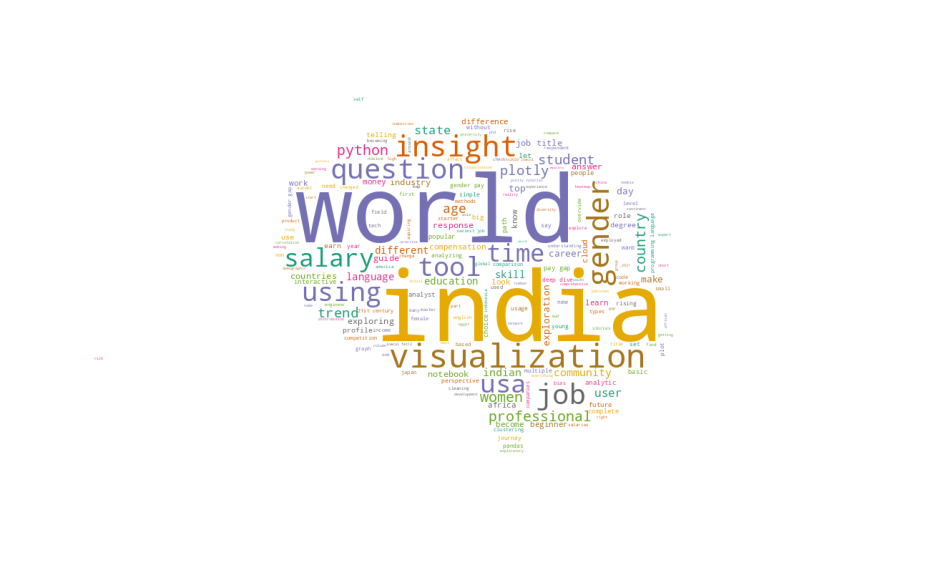

In [12]:
title_corpus = ' '.join(cleaned_kernels_df['title']).lower()

mask = np.array(Image.open('./brain.webp'))

ignorewords = ['kaggler', 'kaggle', 'data', 'scientist', 'survey', 'science', 'analysis', 'story', 'machine', 'learning', 'challenge', 'eda', 'results']
for common in ignorewords:
    title_corpus = title_corpus.replace(common, "")
    
title_wordcloud = WordCloud(background_color='#fff',colormap='Dark2', mask=mask, height=1000, width=2000,min_word_length=3).generate(title_corpus)
plt.figure(figsize=(12,12))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

The wordcloud shows that some of the more frequently analyzed topics include country (especially india), gender, jobs, salary and tools.

### Popular Tags used by participants
In the next plot we examine which are the most popular tags used by participants.

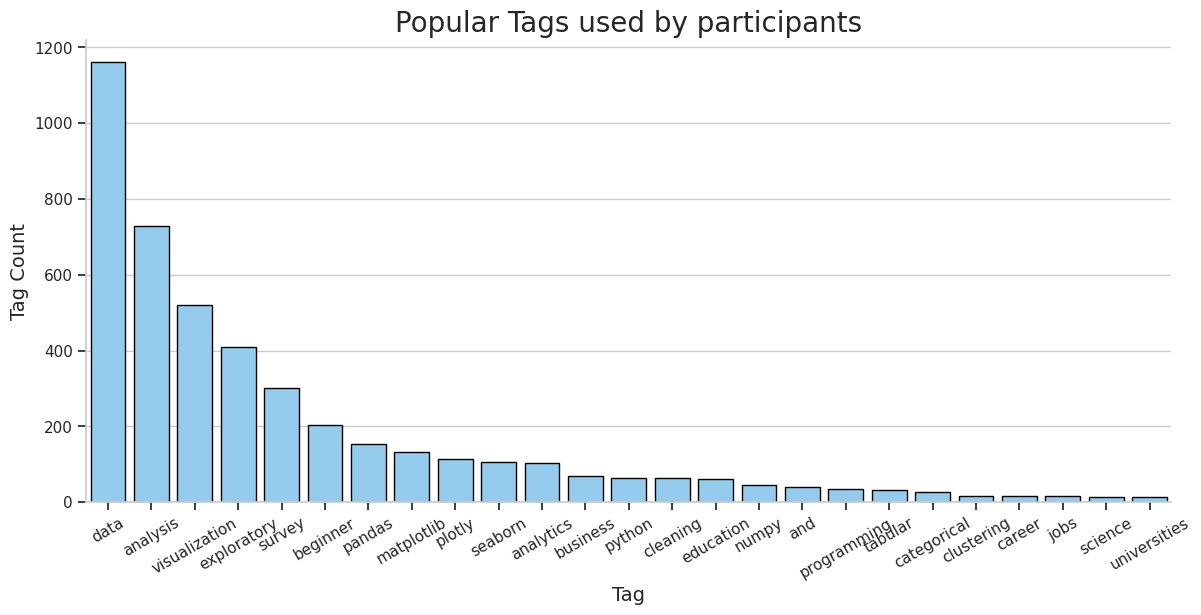

In [28]:
tags_arr = []
for index, row in cleaned_kernels_df.iterrows():
        tags_arr.append(row['tags'])
        
tags = ' '.join(tags_arr).translate(str.maketrans('', '', string.punctuation)).split()
tags_count = Counter(tags)

tags_df = pd.DataFrame(tags_count.items(), columns = ['Tag', 'Tag Count'])
tags_df = tags_df.sort_values(by=['Tag Count'], ascending = False).head(25)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(14,6))

tags_plot = sns.barplot(data=tags_df, 
                        x='Tag',
                        y='Tag Count', 
                        edgecolor='black',
                       color='lightskyblue')
plt.xticks(rotation=30)
plt.title('Popular Tags used by participants',fontsize=20)
plt.xlabel('Tag', fontsize=14);
plt.ylabel('Tag Count', fontsize=14)
plt.tick_params(bottom=True, left=True)

plt.show()

- The five most popular tags are data (used 1161 times), analysis (used 729 times), visualization (used 520 times), exploratory (used 410 times) and survey (used 301 times). We can see they are all related to the theme of the competition.

- More telling are the tags not directly related to competition theme or language used. Of those, the top five are beginner (used 204 times), business (used 69 times), cleaning (used 65 times), education (used 62 times) and programming (used 36 times).

---

## 3) Notebook Success

### Corelation between success parameters
There are a few parameters with which one can measure the success of a notebook. They are the number of votes, comments and views a notebook gets, and also the type of medal it was awarded (if it got one). These parameters are probably correlated, and below we explore what this correlation looks like.

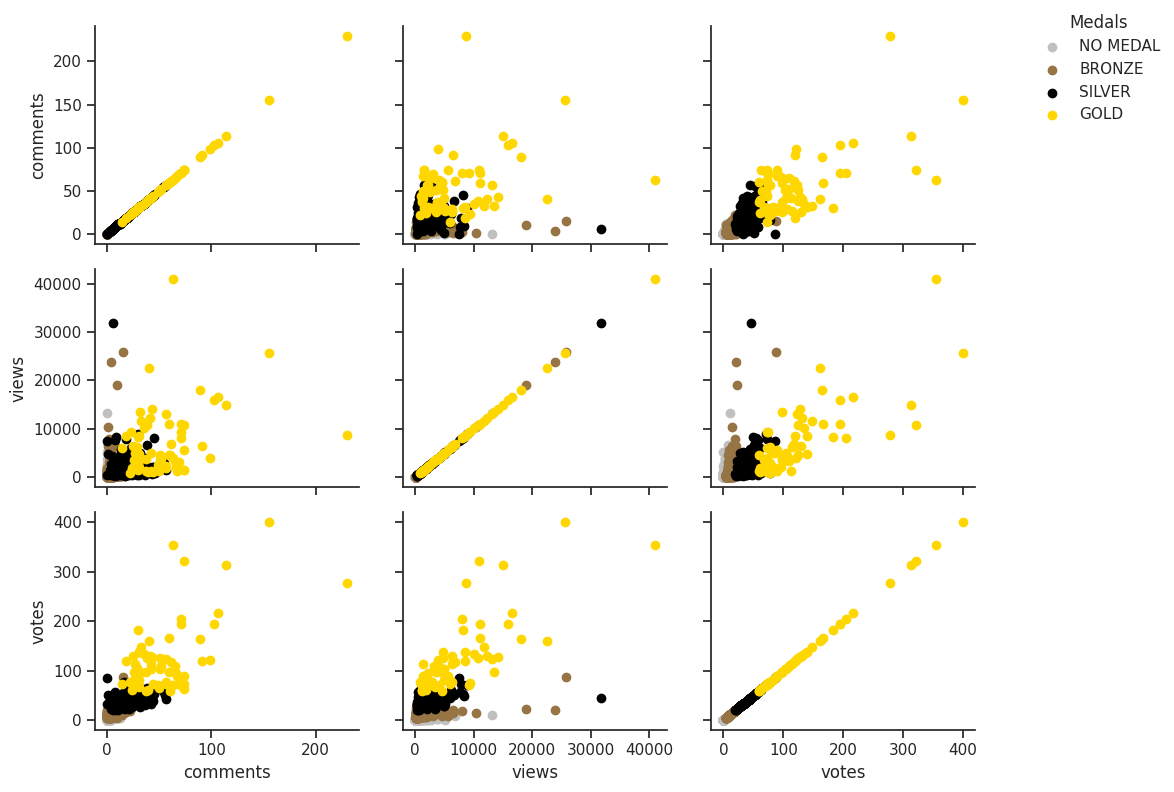

In [29]:
success_df = cleaned_kernels_df[["medal","comments","views",'votes']]
success_df = success_df.replace(np.nan, 'NO MEDAL')

sns.set_theme(style="ticks")
success_plot = sns.PairGrid(data=success_df,
                            hue = 'medal',
                            palette= ['#C0C0C0', '#967444', 'black', 'gold'])
success_plot.map(plt.scatter)
success_plot.add_legend(loc='upper right', title='Medals', label_order=['NO MEDAL', 'BRONZE', 'SILVER', 'GOLD'])
success_plot.fig.set_size_inches(12,8)

plt.show()

- Views vs Votes: Notebooks with more views seem to also get more votes, although there are also cases of notebooks with lots of views and not many votes. Most of the highest viewed notebooks also have a medal. 
- Views vs Comments: Notebooks with more views tedn to get more comments. But there also exist notebooks with lots of comments and fewer views and vice-versa. The notebooks with most views and comments combined also recieved a gold medal.
- Votes vs Comments: Notebooks with more votes also get more comments. The notebooks with most votes and comments combined also recieved a gold medal.

### Medals won by Kaggle Tier
In this graph we explore the corelation between Kaggle tiers and medals won. As some tiers are bigger than others, we don't show the absolute medal counts by each tier. Instead we show the data as what percentage of kagglers in each tier won a medal.

In [ ]:
tiers_medals_df = without_null_df[['tier','medal']]

tiers_medals_df = tiers_medals_df.groupby('tier').medal.value_counts().rename('medalCount').reset_index()

tiers_count = without_null_df.tier.value_counts()
contrubutor_all = tiers_count[0]
novice_all = tiers_count[1]
expert_all = tiers_count[2]
master_all = tiers_count[3]
gm_all = tiers_count[4]
team_all = tiers_count[5]


tiers_medals_df['medalCount'] = np.where(tiers_medals_df.tier == 'Contributor',100*tiers_medals_df.medalCount/contrubutor_all, tiers_medals_df.medalCount)
tiers_medals_df['medalCount'] = np.where(tiers_medals_df.tier == 'Novice',100*tiers_medals_df.medalCount/novice_all , tiers_medals_df.medalCount)
tiers_medals_df['medalCount'] = np.where(tiers_medals_df.tier == 'Expert',100*tiers_medals_df.medalCount/expert_all, tiers_medals_df.medalCount)
tiers_medals_df['medalCount'] = np.where(tiers_medals_df.tier == 'Master',100*tiers_medals_df.medalCount/master_all, tiers_medals_df.medalCount)
tiers_medals_df['medalCount'] = np.where(tiers_medals_df.tier == 'GrandMaster',100*tiers_medals_df.medalCount/gm_all, tiers_medals_df.medalCount)
tiers_medals_df['medalCount'] = np.where(tiers_medals_df.tier == 'KaggleTeam',100*tiers_medals_df.medalCount/team_all, tiers_medals_df.medalCount)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(14,6))

tiers_medals_plot = sns.barplot(data=tiers_medals_df,
                                x='tier', 
                                y='medalCount',
                                hue='medal',
                                order=['Novice', 'Contributor', 'Expert', 'Master', 'GrandMaster', 'KaggleTeam'],
                                edgecolor='black', 
                                palette= ['#967444', '#C0C0C0', 'gold'])                
plt.title('Medal won percentage by Kaggle tier',fontsize=20)
plt.xlabel('Kaggle Tier', fontsize=14);
plt.ylabel('Medal won percentagee', fontsize=14)
plt.tick_params(bottom=True, left=True)
plt.legend(loc='upper left', title='Medals')

plt.show()

As can be seen in the graph, the more experienced a kaggler is, the more chance he has to get a medal. Novices seem to have it out for themselves, as only 17% managed to grab a medal (mostly bronze, no gold). GrandMasters show us why they deserve that title, as 43%% of their submissions were awarded the gold medal. Teaming up seems to help as well, as almost all of KaggleTeams managed to grab at least a bronze medal.

### Average Vote by Kaggle Tier
Here we explore how the number of upvotes is correlated to Kaggle tiers.

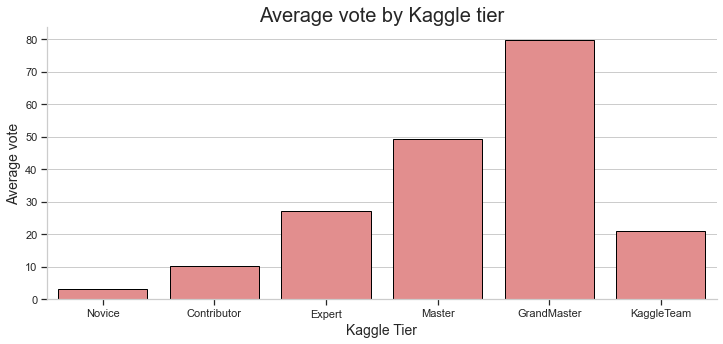

In [150]:
tiers_votes_df = without_null_df[['tier','votes']]

tiers_votes_mean_df = tiers_votes_df.groupby('tier').agg('mean')

tiers_votes_mean_df.reset_index(inplace=True)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(14,6))

tiers_votes_plot = sns.barplot(data=tiers_votes_mean_df,
                               x='tier',
                               y='votes',
                               order=['Novice', 'Contributor', 'Expert', 'Master', 'GrandMaster', 'KaggleTeam'],
                               edgecolor='black',
                               color='lightcoral')
plt.title('Average Vote by Kaggle tier',fontsize=20)
plt.xlabel('Kaggle Tier', fontsize=14);
plt.ylabel('Average Vote', fontsize=14)
plt.tick_params(bottom=True, left=True)

plt.show()

We see that the more experienced a kaggler is, the higher is his average vote. Novices again fare the worst, with only 3.7 average votes. Contributors follow with 8.6 average votes, then KaggleTeams with 13.1, Experts with 19.5 and Masters with 35. GrandMasters exceed all with 77.2 votes on average.

---

# **Conclusion**

---

# Remarks
[1] *The questions are Q21, Q12, Q12, Q42, respectively.*

[2] *The questions are Q19, Q28, Q16, Q16, Q17, respectively.*

---

# References